# Load Package

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zwjh3bzn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zwjh3bzn
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch, torchvision, math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip, cv2, copy
from PIL import Image
from scipy.ndimage import filters
from torch import nn
from functools import reduce
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch._C import _infer_size, _add_docstr
from typing import Callable, List, Optional, Tuple, Union
from collections import OrderedDict
from sklearn.manifold import TSNE
from matplotlib.ticker import NullFormatter
import warnings
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data Preprocessing functions

In [3]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

## Custom Your model
Here, I demonstrate how to interpret your custom deep learning model, so that I rewrite the inference head of the original CLIP model.

In [4]:
Tensor = torch.Tensor
linear = torch._C._nn.linear

In [5]:
def scaled_dot_product_attention(
    q: Tensor,
    k: Tensor,
    v: Tensor,
    attn_mask: Optional[Tensor] = None
) -> Tuple[Tensor, Tensor]:
    B, Nt, E = q.shape
    q = q / math.sqrt(E)
    # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
    if attn_mask is not None:
        attn = torch.baddbmm(attn_mask, q, k.transpose(-2, -1))
    else:
        attn = torch.bmm(q, k.transpose(-2, -1))
    attn = F.softmax(attn, dim=-1)
    output = torch.bmm(attn, v)
    return output, attn

In [6]:
def _in_projection(
    q: Tensor,
    k: Tensor,
    v: Tensor,
    w_q: Tensor,
    w_k: Tensor,
    w_v: Tensor,
    b_q: Optional[Tensor] = None,
    b_k: Optional[Tensor] = None,
    b_v: Optional[Tensor] = None,
) -> Tuple[Tensor, Tensor, Tensor]:
    Eq, Ek, Ev = q.size(-1), k.size(-1), v.size(-1)
    assert w_q.shape == (Eq, Eq), f"expecting query weights shape of {(Eq, Eq)}, but got {w_q.shape}"
    assert w_k.shape == (Eq, Ek), f"expecting key weights shape of {(Eq, Ek)}, but got {w_k.shape}"
    assert w_v.shape == (Eq, Ev), f"expecting value weights shape of {(Eq, Ev)}, but got {w_v.shape}"
    assert b_q is None or b_q.shape == (Eq,), f"expecting query bias shape of {(Eq,)}, but got {b_q.shape}"
    assert b_k is None or b_k.shape == (Eq,), f"expecting key bias shape of {(Eq,)}, but got {b_k.shape}"
    assert b_v is None or b_v.shape == (Eq,), f"expecting value bias shape of {(Eq,)}, but got {b_v.shape}"
    return linear(q, w_q, b_q), linear(k, w_k, b_k), linear(v, w_v, b_v)


In [7]:
class DecoupledAttentionPooling2D(nn.Module):
    def __init__(self, layer):
        super(DecoupledAttentionPooling2D, self).__init__()
        self.positional_embedding = layer.positional_embedding
        self.k_proj = layer.k_proj
        self.q_proj = layer.q_proj
        self.v_proj = layer.v_proj
        self.num_heads = layer.num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC

        #AttentionPooling2D part
        query, key, value = x[:1], x, x
        q_proj_weight=self.q_proj.weight
        k_proj_weight=self.k_proj.weight
        v_proj_weight=self.v_proj.weight
        in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias])
        embed_dim_to_check, num_heads = x.shape[-1], self.num_heads

        tgt_len, bsz, embed_dim = query.shape
        src_len, _, _ = key.shape
        assert embed_dim == embed_dim_to_check, f"was expecting embedding dimension of {embed_dim_to_check}, but got {embed_dim}"
        if isinstance(embed_dim, torch.Tensor):
            head_dim = embed_dim.div(num_heads, rounding_mode='trunc')
        else:
            head_dim = embed_dim // num_heads
        assert head_dim * num_heads == embed_dim, f"embed_dim {embed_dim} not divisible by num_heads {num_heads}"

        # allow MHA to have different embedding dimensions when separate projection weights are used
        assert key.shape[:2] == value.shape[:2], f"key's sequence and batch dims {key.shape[:2]} do not match value's {value.shape[:2]}"

        b_q, b_k, b_v = in_proj_bias.chunk(3)
        q, k, v = _in_projection(query, key, value, q_proj_weight, k_proj_weight, v_proj_weight, b_q, b_k, b_v)

        q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
        k = k.contiguous().view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
        v = v.contiguous().view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)

        src_len = k.size(1)

        attn_output, attn_output_weights = scaled_dot_product_attention(q, k, v)
        attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, embed_dim)
        return attn_output

In [8]:
class OutputProjector(nn.Module):
    def __init__(self, layer):
        super(OutputProjector, self).__init__()
        self.c_proj = layer.c_proj

    def forward(self, x):
        out_proj_weight = self.c_proj.weight
        out_proj_bias = self.c_proj.bias
        linear_projection = linear(x, out_proj_weight, out_proj_bias)
        return linear_projection

In [9]:
class ImageEncoder(nn.Module):
    def __init__(self, model):
        super(ImageEncoder, self).__init__()
        orderDict = OrderedDict()
        for name, layer in model.named_children():
            if name != 'attnpool':
                orderDict[name] = layer
            else:
                break

        self.ResnetBackbone = nn.Sequential(orderDict)
        self.AttentionPooling2D = DecoupledAttentionPooling2D(model.attnpool)
        self.OutputProjector = OutputProjector(model.attnpool)
        self.hook = None

    def forward(self, x):
        x = self.ResnetBackbone(x)
        bsz = x.size(0)
        #attn_output: [bsz, embed_dim]
        #output: [bsz, output_dim]
        if self.hook is not None:
            self.hook.remove()
        attn_output = self.AttentionPooling2D(x)
        linear_projection = self.OutputProjector(attn_output)

        linear_projection = linear_projection.view(-1, bsz, linear_projection.size(1))
        output = linear_projection.squeeze(0)
        return output, attn_output

# DecomCAM

In [10]:
def batch_similarity(x, y):
    x, y = x.unsqueeze(1), y.unsqueeze(1)
    x, y = F.normalize(x), F.normalize(y)
    return torch.bmm(x, y.transpose(1,2)).flatten()

In [11]:
class Hook:
    """Attaches to a module and records its activations and gradients."""
    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

## Stage1.1 Semantic Activation Map

In [12]:
def gradSAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    if input.grad is not None:
        input.grad.data.zero_()

    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.


        output, attn_output = model(input)
        # Here we use GradCAM to get the gradient map, you can also make modification to implement GradCAM++ version
        linear_hook = attn_output.register_hook(lambda grad: grad)
        attn_output.retain_grad()


        cosine_similarity = F.cosine_similarity(output.float(), target.float())


        cosine_similarity.backward()

        print("cosine_similarity of input image and caption:", cosine_similarity)

        threshold = 0
        grad = hook.gradient.float()
        act = hook.activation.float()


        alpha = grad.mean(dim=(2, 3), keepdim=True)
        grad_sam = torch.sum(act * alpha, dim=1, keepdim=True)
        grad_sam = torch.clamp(grad_sam, min=threshold)
        linear_hook.remove()

    grad_sam = F.interpolate(
        grad_sam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return grad_sam, alpha, act, attn_output, grad

In [13]:
clip_model = "RN101" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
model, preprocess = clip.load(clip_model, device=device, jit=False, download_root='D:\Development\clip')

In [14]:
image_encoder = ImageEncoder(model.visual)#.half()

## Download Image

In [16]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [38]:
image_path = '/content/{HOME}/dog.jpeg'
image_caption = 'tall building'

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

cosine_similarity of input image and caption: tensor([0.3774], grad_fn=<SumBackward1>)


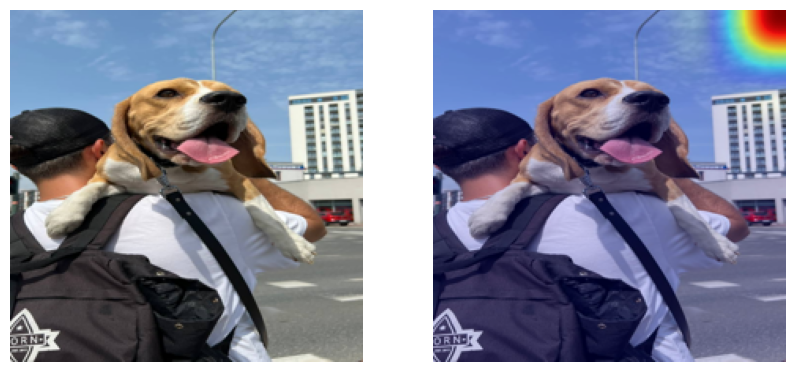

In [39]:
blur = True
target = model.encode_text(text_input)#.half()
vis_image = image_np
image_input = image_input#.half()

attn_map, alpha, act, attn_output, grad = gradSAM(
    image_encoder,
    image_input,
    target,
    getattr(image_encoder.ResnetBackbone, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()
viz_attn(vis_image, attn_map, blur)

## Stage1.2 Decomposition with SVD (PCA)

In [40]:
p_attn_maps = []
p = 100
n_components = 10
descending = True
alpha = torch.flatten(alpha.detach().cpu())

values = torch.sort(alpha, descending=descending).values.numpy()
indices = torch.sort(alpha, descending=descending).indices.numpy()
alpha = alpha.unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)

X = act[:,indices.tolist()[:p],:,:]*alpha[:,indices.tolist()[:p],:,:]
# X = act[:,indices.tolist()[:p],:,:]*alpha[:,indices.tolist()[:p],:,:]
width, height = X.size(2), X.size(3)

X = X.flatten(start_dim=2).squeeze(0).T.detach().cpu()
pca = PCA(n_components=n_components)
# pca.fit(X)
pca_result = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
for i in range(n_components):
    newX = pca_result[:,i].flatten()
    # newX = pca.fit_transform(pca.fit_transform(X))[:, 0].flatten()

    tmp_act = torch.from_numpy(newX.reshape(width,height)).unsqueeze(0).unsqueeze(0).to(device)

    grad_sam = tmp_act
    grad_sam = torch.clamp(grad_sam, min=0)
    grad_sam = F.interpolate(grad_sam,
        image_input.half().shape[2:],
        mode='bicubic',
        align_corners=False)
    attn_map_tmp = grad_sam.squeeze().detach().cpu().numpy()
    p_attn_maps.append(attn_map_tmp)
    viz_attn(vis_image, attn_map_tmp, blur)

Output hidden; open in https://colab.research.google.com to view.

## Stage2 Integration

In [41]:
def gaussian_blur_image(image_np, sigma=10, truncate=4):
    assert image_np.shape[2] == 3, 'the image should be transformed into 3 channel'
    image_blur = np.zeros(image_np.shape)
    for i in range(3):
        image_blur[:,:,i] = filters.gaussian_filter(image_np[:,:,i], sigma, truncate=truncate)
    return image_blur

def NpImage2Tensor(clip, preprocess, image_np):
    image_pil = Image.fromarray(np.uint8(image_np*255))
    image_input = preprocess(image_pil).unsqueeze(0).to(device)
    return clip(image_input)

def getImageTextSim(image_embed, text_embed):
    return F.cosine_similarity(image_embed, text_embed)

In [42]:
image_blur = gaussian_blur_image(image_np, sigma=10, truncate=100)
# plt.imshow(image_blur)

In [43]:
class MinMaxNormalize():
    def __init__(self, lst=None):
        if lst is not None:
            self.lst_min = min(lst)
            self.lst_max = max(lst)

    def fit(self, lst):
        self.lst_min = min(lst)
        self.lst_max = max(lst)
        return None

    def fit_transform(self, lst):
        self.lst_min = min(lst)
        self.lst_max = max(lst)
        return list(map(lambda x: (x-min(lst))/(max(lst)-min(lst)), lst))

    def transformVal(self, val):
        return (val-self.lst_min)/(self.lst_max-self.lst_min)


class ScaleNormalize():
    def __init__(self, lst=None):
        if lst is not None:
            self.lst_min = min(lst)
            self.lst_max = max(lst)

    def fit(self, lst):
        self.lst_min = min(lst)
        self.lst_max = max(lst)
        return None

    def fit_transform(self, lst):
        self.lst_min = min(lst)
        self.lst_max = max(lst)
        return list(map(lambda x: x/max(lst), lst))

    def transformVal(self, val):
        return val/self.lst_max

def getFuzzySet(bol_set, val):
    fuzzy_set = (bol_set+0.)*val
    fuzzy_set = np.clip(fuzzy_set, 0., np.max(fuzzy_set))
    return fuzzy_set

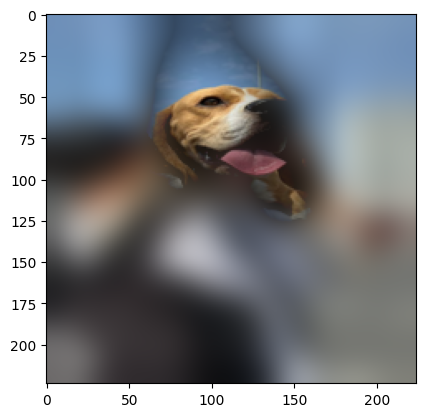

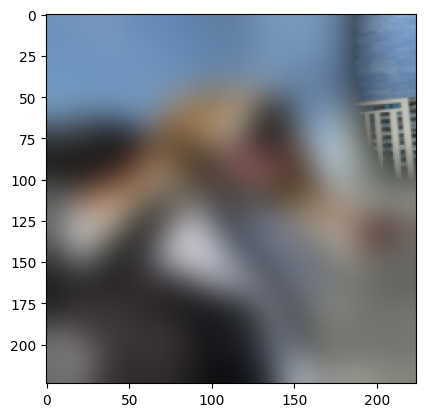

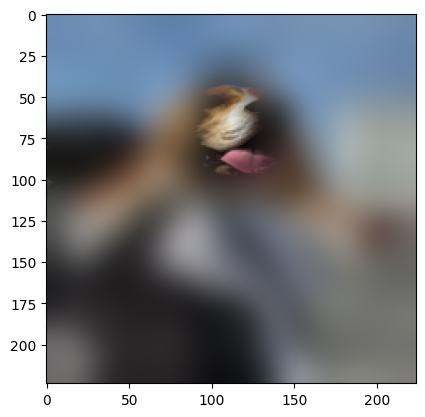

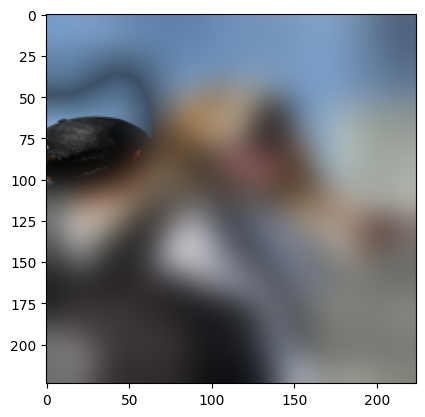

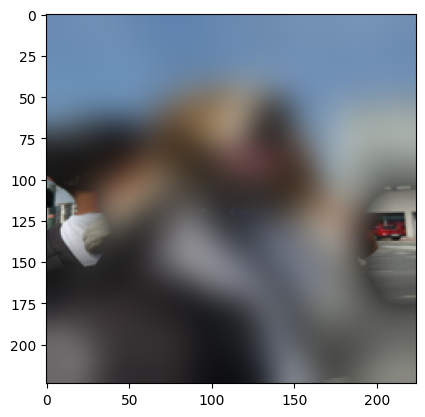

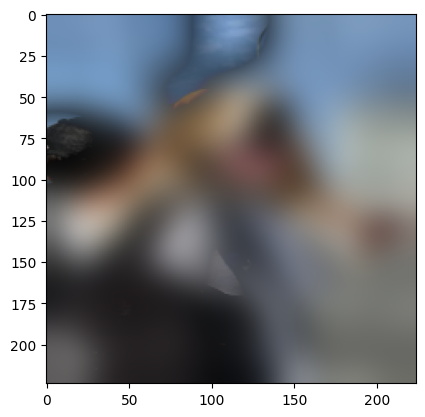

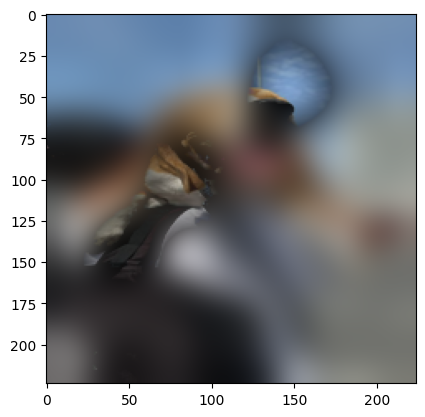

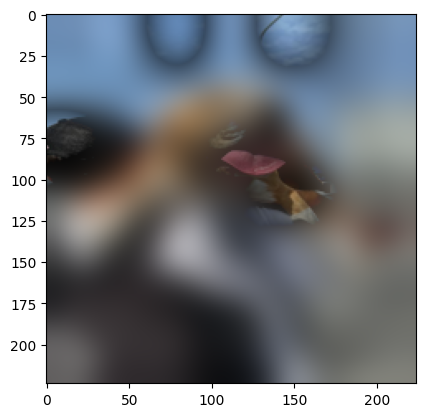

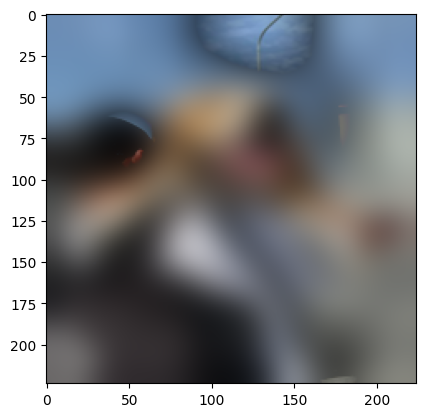

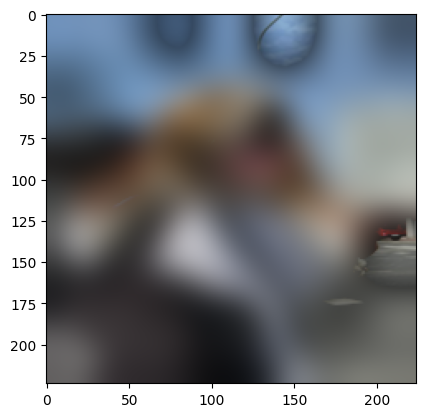

In [44]:
image_maskeds = []
image_masked_indexs = []
image_masked_alphas = []
text_embed = target #model.encode_text(text_input)

sim0 = getImageTextSim(NpImage2Tensor(model.visual, preprocess, image_blur), text_embed).item()

for index, attn_map in enumerate(p_attn_maps):
    #generate masked principle component
    mask = normalize(attn_map)

    image_masked = np.maximum(vis_image*mask[:,:,None], image_blur*(1-mask[:,:,None]))
    image_masked_index = vis_image*mask[:,:,None]>image_blur*(1-mask[:,:,None])
    image_maskeds.append(image_masked)

    #calculate the important weight of each masked principle component
    sim = getImageTextSim(NpImage2Tensor(model.visual, preprocess, image_masked), text_embed).item()
    image_masked_alphas.append(sim-sim0)
    image_masked_indexs.append(getFuzzySet(image_masked_index, sim-sim0))

    image_masked_pil = Image.fromarray(np.uint8(image_masked*255))
    plt.imshow(image_masked)
    plt.show()

In [45]:
def scale(matrix, alpha):
    return np.tanh(alpha*matrix)

def dtanh(x):
    return 1-np.tanh(x)**2

[0.005555152893066406, 0.023610562086105347, 0.0006872713565826416, 0.0007783770561218262, -0.007997572422027588, 0.0014371871948242188, 0.0014062821865081787, -0.007258206605911255, 0.0065323710441589355, 0.007680028676986694]


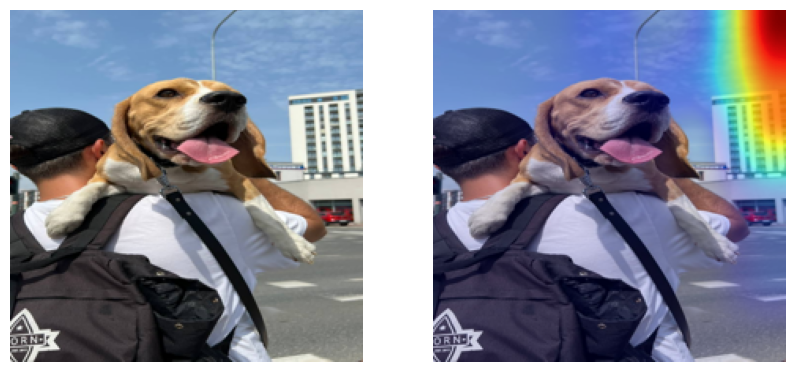

In [46]:
decomcam = None
scaleNormalizer = ScaleNormalize()
scaleNormalizer.fit(image_masked_alphas)

print(image_masked_alphas)
for attn_map, alpha, p in zip(p_attn_maps, image_masked_alphas, pca.explained_variance_ratio_):

    alpha = 0. if alpha < 0.01 else scaleNormalizer.transformVal(alpha)
    if decomcam is None:
        decomcam = 0. #alpha * attn_map * p
    decomcam += alpha * attn_map # * p

viz_attn(vis_image, decomcam, blur)